In [1]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 34.8 MB/s eta 0:00:00


In [ ]:
#!pip install radiomics

In [2]:
pip install pyradiomics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 53.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 65.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

In [43]:
import os
import numpy as np
import glob
import re
import pandas as pd
import radiomics
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import SimpleITK as sitk
from radiomics import featureextractor, getFeatureClasses
import logging
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score

In [4]:
!pip install natsort

In [5]:
from natsort import natsorted

In [6]:
import pkg_resources
version = pkg_resources.get_distribution("pyradiomics").version  # 3.0.1 version required
print(version)

3.0.1


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [9]:
# Set up logging to only show warnings or higher level messages
logger = logging.getLogger('radiomics')
logger.setLevel(logging.WARNING)

In [10]:
root_path_BM = r'/content/drive/MyDrive/Dissertation/Dataset/Full Data/BM'
root_path_FM = r'/content/drive/MyDrive/Dissertation/Dataset/Full Data/FM'

In [11]:
# Define a function to get sorted file paths
def get_sorted_paths(root_path, image_exts, mask_ext):
    image_paths = []
    mask_paths = []

    # Collect image paths
    for ext in image_exts:
        image_paths.extend(glob.glob(os.path.join(root_path, f'*{ext}')))

    # Collect mask paths
    mask_paths.extend(glob.glob(os.path.join(root_path, f'*{mask_ext}')))

    # Sort the paths
    sorted_image_paths = natsorted(image_paths)
    sorted_mask_paths = natsorted(mask_paths)

    return sorted_image_paths, sorted_mask_paths

# Get sorted paths for BM and FM datasets
images_BM, masks_BM = get_sorted_paths(root_path_BM, ['.jpg', '.jpeg'], '.tif')
images_FM, masks_FM = get_sorted_paths(root_path_FM, ['.jpg', '.jpeg'], '.tif')

In [12]:
# Function to load and preprocess images
def load_and_preprocess_images(filepaths, img_height=256, img_width=256, color_mode='rgb'):
    images = []
    for path in filepaths:
        image = load_img(path, target_size=(img_height, img_width), color_mode=color_mode)
        image = img_to_array(image) / 255.0  # Normalize pixel values
        images.append(image)
    return np.array(images)

# Function to load and preprocess test data with mask files
def load_test_data_with_masks(test_directory, mask_directory, img_height=256, img_width=256):
    test_files = test_directory
    mask_files = mask_directory

    if not test_files:
        print(f"No image files found in {test_directory}")
    if not mask_files:
        print(f"No mask files found in {mask_directory}")

    test_images = load_and_preprocess_images(test_files, img_height, img_width, color_mode='rgb')
    test_masks = load_and_preprocess_images(mask_files, img_height, img_width, color_mode='grayscale')  # Ensure masks are binary

    return test_images, test_masks, test_files, mask_files

# Function to resample the mask to match the image geometry
def resample_image_and_mask(image, mask):
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(image)
    resample.SetInterpolator(sitk.sitkNearestNeighbor)
    resample.SetDefaultPixelValue(0)
    resample.SetOutputPixelType(mask.GetPixelID())
    resampled_mask = resample.Execute(mask)
    return image, resampled_mask

# Define a function to extract radiomic features using PyRadiomics
def extract_radiomic_features(img_path, mask_path, extractor):
    image = sitk.ReadImage(img_path, sitk.sitkFloat32)
    mask = sitk.ReadImage(mask_path, sitk.sitkUInt8)

    # Check if the geometries match, resample if necessary
    if image.GetSpacing() != mask.GetSpacing() or image.GetOrigin() != mask.GetOrigin():
        image, mask = resample_image_and_mask(image, mask)

    # Set geometry tolerance
    extractor.settings['geometryTolerance'] = 1e-3

    features = extractor.execute(image, mask)
    return features



In [31]:
def plot_confusion_matrix(y_true, y_pred, model_name="Radiomics Model"):

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Actinomycetoma', 'Eumycetoma'], yticklabels=['Actinomycetoma', 'Eumycetoma'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


In [14]:


# Load bacterial test images and masks
test_images_bacterial, test_masks_bacterial, test_files_bacterial, test_mask_files_bacterial = load_test_data_with_masks(images_BM, masks_BM)
# Load fungal test images and masks
test_images_fungal, test_masks_fungal, test_files_fungal, test_mask_files_fungal = load_test_data_with_masks(images_FM, masks_FM)


# Initialize PyRadiomics feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.disableAllFeatures()  # Disable all features to start with
extractor.enableImageTypes(Original={}, LoG={}, Wavelet={})
extractor.enableFeaturesByName(shape2D=[], glcm=[], glrlm=[], glszm=[], gldm=[], firstorder=[])

# Extract radiomic features from images and masks
radiomic_features_BM = []
radiomic_features_FM = []

for img_path, mask_path in zip(test_files_bacterial, test_mask_files_bacterial):
    features = extract_radiomic_features(img_path, mask_path, extractor)
    radiomic_features_BM.append(features)


for img_path, mask_path in zip(test_files_fungal, test_mask_files_fungal):
    features = extract_radiomic_features(img_path, mask_path, extractor)
    radiomic_features_FM.append(features)

# Converting features to DataFrame
features_df_BM = pd.DataFrame(radiomic_features_BM)
features_df_FM = pd.DataFrame(radiomic_features_FM)

# Ensuring DataFrame is not empty
if features_df_BM.empty:
    raise ValueError("Feature extraction resulted in an empty DataFrame.")

if features_df_FM.empty:
    raise ValueError("Feature extraction resulted in an empty DataFrame.")

# Drop specified diagnostic columns
columns_to_drop = [
    'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
    'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
    'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings',
    'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Hash',
    'diagnostics_Image-original_Dimensionality', 'diagnostics_Image-original_Spacing'
]

features_df_BM = features_df_BM.drop(columns=columns_to_drop)

features_df_FM = features_df_FM.drop(columns=columns_to_drop)

# Saving the DataFrame to a CSV file
features_df_BM.to_csv('radiomic_features_with_labels_BM.csv', index=False)

features_df_FM.to_csv('radiomic_features_with_labels_FM.csv', index=False)

#print the DataFrame to the console
print(features_df_BM.head())
print(features_df_FM.head())

Streaming output truncated to the last 5000 lines.
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is s

  diagnostics_Image-original_Size  diagnostics_Image-original_Mean  \
0                      (800, 600)                       165.949033   
1                      (800, 600)                       171.696010   
2                      (800, 600)                       131.315920   
3                      (800, 600)                       158.749627   
4                      (800, 600)                       128.527747   

   diagnostics_Image-original_Minimum  diagnostics_Image-original_Maximum  \
0                              4.4815                          253.269608   
1                             16.2418                          255.000000   
2                              3.0623                          253.125397   
3                              6.3373                          253.197495   
4                             11.3295                          252.909103   

             diagnostics_Mask-original_Hash diagnostics_Mask-original_Spacing  \
0  d26564ea7038db77a9741d76c2042b66

In [15]:
from IPython.display import display
display(features_df_BM)

,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,...,wavelet-LL_firstorder_Mean,wavelet-LL_firstorder_Median,wavelet-LL_firstorder_Minimum,wavelet-LL_firstorder_Range,wavelet-LL_firstorder_RobustMeanAbsoluteDeviation,wavelet-LL_firstorder_RootMeanSquared,wavelet-LL_firstorder_Skewness,wavelet-LL_firstorder_TotalEnergy,wavelet-LL_firstorder_Uniformity,wavelet-LL_firstorder_Variance
0,"(800, 600)",165.949033,4.481500,253.269608,d26564ea7038db77a9741d76c2042b6692994e9d,"(1.0, 1.0)","(800, 600)","(227, 209, 222, 212)",27424,1,...,123.60756336063876,114.51772689819336,29.770065307617188,442.43016052246094,27.541042094108846,134.58982434735918,1.7660811444328177,496769876.5088006,0.15811230968300727,2835.59109789867
1,"(800, 600)",171.696010,16.241800,255.000000,533722bdfe0e76fd5213359ed6f505771e0343c0,"(1.0, 1.0)","(800, 600)","(35, 0, 765, 600)",367841,1,...,337.0368836330162,337.4554748535156,29.100391387939453,510.5788688659668,26.959015988952775,342.55471555001293,-0.6317317953519556,43163836143.992355,0.13708874615052669,3749.8722164949972
2,"(800, 600)",131.315920,3.062300,253.125397,7328160e54062819dd5882d5392c4630c3494496,"(1.0, 1.0)","(800, 600)","(123, 32, 330, 426)",101417,1,...,212.8509937894106,208.2213134765625,15.097827911376953,441.9176445007324,17.092739721285128,215.50673926512403,0.7935174510926307,4710125417.034143,0.22549285395676152,1137.6091115464483
3,"(800, 600)",158.749627,6.337300,253.197495,3204db87c72d5bbf9445017ebff717e9bf7c9127,"(1.0, 1.0)","(800, 600)","(330, 15, 256, 284)",55578,1,...,208.94003430790383,188.49295043945312,33.61906051635742,462.8848457336426,29.11780576235926,222.06458662140247,1.4223572992289564,2740700164.1283007,0.15100040380404442,5656.742694746325
4,"(800, 600)",128.527747,11.329500,252.909103,6317372e275ebc45613d7fdb4d804133ddbd68b2,"(1.0, 1.0)","(800, 600)","(25, 192, 249, 159)",23035,1,...,235.1274714554989,230.90835571289062,68.07743835449219,377.7445831298828,18.49778673062477,238.41480267961157,0.39995466343769676,1309346673.7802231,0.2048068037007698,1556.6903037016643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,"(800, 600)",186.755403,11.983600,255.000000,8f4e91235d583307c152a34af9b4b9eb30afb0e8,"(1.0, 1.0)","(800, 600)","(440, 87, 137, 158)",17592,1,...,260.3261767292413,261.45420837402344,64.650146484375,460.81048583984375,17.944982252518116,263.0308257589481,0.7574981685624731,1217106307.547645,0.21801859531007625,1415.4970089699602
316,"(800, 600)",186.755403,11.983600,255.000000,7804122d9948c97aeda75408e632f5937cb4c856,"(1.0, 1.0)","(800, 600)","(199, 278, 379, 292)",72947,1,...,305.24119052423896,280.89959716796875,56.021728515625,483.18231201171875,34.07779933009773,317.93726787970985,1.4739415886148355,7373782302.763189,0.17490010071024828,7911.921914159611
317,"(800, 600)",155.663561,19.249001,255.000000,854318ce8d77581680d0651945597658ea2344f7,"(1.0, 1.0)","(800, 600)","(434, 24, 239, 319)",50717,1,...,342.19776244274175,343.9869384765625,115.94143676757812,412.4583435058594,17.320452404322218,343.78826489032826,-0.4069915881871317,5994261049.876834,0.22233667152578918,1091.062455483386
318,"(800, 600)",155.663561,19.249001,255.000000,5d17644bd4e2755872f5f53b433a87961d7acc9b,"(1.0, 1.0)","(800, 600)","(151, 314, 96, 117)",7987,1,...,295.9043518148556,295.37744140625,119.06400299072266,401.30904388427734,17.00849860692827,298.3285622609427,1.544099113697103,710842449.3816606,0.22812453672801128,1440.5456377113674


In [16]:
display(features_df_FM)

,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,...,wavelet-LL_firstorder_Mean,wavelet-LL_firstorder_Median,wavelet-LL_firstorder_Minimum,wavelet-LL_firstorder_Range,wavelet-LL_firstorder_RobustMeanAbsoluteDeviation,wavelet-LL_firstorder_RootMeanSquared,wavelet-LL_firstorder_Skewness,wavelet-LL_firstorder_TotalEnergy,wavelet-LL_firstorder_Uniformity,wavelet-LL_firstorder_Variance
0,"(800, 600)",116.883778,2.627900,255.000000,3a6282affc4321bcf4d5795a0946abfe9766ca59,"(1.0, 1.0)","(800, 600)","(12, 0, 788, 534)",264048,1,...,165.98802820027745,106.37025451660156,1.6136093139648438,544.2458877563477,78.96511668450849,223.71571600166402,1.2663235428811797,13215264837.376354,0.0917340207418379,22496.696080321104
1,"(800, 600)",124.846724,4.696200,255.000000,ed381a86467f816f67d0f5113abf4f5742f6753d,"(1.0, 1.0)","(800, 600)","(113, 81, 465, 416)",99488,1,...,139.94722578102042,92.79442596435547,10.185790061950684,537.7902231216431,52.28462363067822,188.58939261686393,1.6854071137794986,3538386129.747875,0.11219767964470856,15980.73300379375
2,"(800, 600)",127.362763,4.696200,255.000000,6a1663f9fe9c9ada68e7d605c260d046785d5794,"(1.0, 1.0)","(800, 600)","(257, 139, 199, 184)",25079,2,...,164.02135845721114,114.73051452636719,10.136268615722656,536.9286727905273,70.63986757030237,217.1429079075276,1.3131301879765795,1182500993.7173338,0.08511349679094765,20248.036424388058
3,"(800, 600)",125.476956,7.479500,255.000000,7df6ec321f57336f36c7940d2e9cc3636ff059d0,"(1.0, 1.0)","(800, 600)","(288, 286, 108, 131)",8546,1,...,179.96706892616598,139.79872131347656,17.97968864440918,516.5085926055908,54.73228419328055,214.88550538471424,1.430581195433518,394618219.5072989,0.09680032274231949,13787.634526568676
4,"(800, 600)",132.904838,5.528800,254.423203,6411c83863e0f84b8a9700301fceb1ee88d9b299,"(1.0, 1.0)","(800, 600)","(261, 232, 236, 185)",27500,1,...,139.23880403556825,114.10747146606445,8.263323783874512,523.8643007278442,49.11740875285535,169.82980262575148,1.3654107488659926,793159451.1472969,0.09968568859504134,9454.717310646334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,"(800, 600)",177.245898,13.752500,252.415802,d2e39d437ddc58147372e966362f0bff15574c07,"(1.0, 1.0)","(800, 600)","(110, 37, 537, 434)",181283,1,...,328.629878352021,328.72967529296875,50.14437484741211,440.41769790649414,21.86149601555821,331.21976848501475,-0.1316280573914041,19887929790.798264,0.17421924547884748,1708.9380896026364
360,"(800, 600)",159.033136,17.615900,251.622498,583024f363cc069b73392f4251e4693027298e4f,"(1.0, 1.0)","(800, 600)","(0, 0, 800, 598)",374267,1,...,326.85910824243285,327.4223937988281,38.43209457397461,469.22632217407227,27.937312408297924,331.5794694304044,-0.2912158788171981,41148764561.052185,0.13477762784262826,3108.0679067100973
361,"(800, 600)",154.694022,16.544001,251.558197,a2ee6abbeb5f1fb123e9af93a2ef2a6fd9a247a5,"(1.0, 1.0)","(800, 600)","(0, 0, 760, 409)",191385,1,...,324.4312981062456,325.787353515625,45.21847915649414,472.3356590270996,27.23536831126264,328.45495587100095,-0.2487821436234828,20647122508.26219,0.14065891912491468,2626.9908453175894
362,"(800, 600)",151.530317,10.748700,255.000000,b55b4c0c3457ebd38b5a89f5509f27e3c0b2edc9,"(1.0, 1.0)","(800, 600)","(363, 98, 221, 307)",35245,1,...,258.9087880929694,245.39688110351562,15.681660652160645,527.9003095626831,46.29179922020235,272.3724705504454,0.703316441619016,2614712451.8462334,0.08885522156368042,7153.0021619830895


In [17]:
hashable_columns = [col for col in features_df_BM.columns if features_df_BM[col].apply(lambda x: isinstance(x, (int, float, str, bool))).all()]

# Filter out columns with the same value in all rows
for column in hashable_columns:
    if features_df_BM[column].nunique() == 1:
        features_df_BM = features_df_BM.drop(columns=[column])

# Save the DataFrame to a CSV file
features_df_BM.to_csv('radiomic_features_with_labels_New_BM.csv', index=False)

# Print the DataFrame to the console
print(features_df_BM.head())

  diagnostics_Image-original_Size  diagnostics_Image-original_Mean  \
0                      (800, 600)                       165.949033   
1                      (800, 600)                       171.696010   
2                      (800, 600)                       131.315920   
3                      (800, 600)                       158.749627   
4                      (800, 600)                       128.527747   

   diagnostics_Image-original_Minimum  diagnostics_Image-original_Maximum  \
0                              4.4815                          253.269608   
1                             16.2418                          255.000000   
2                              3.0623                          253.125397   
3                              6.3373                          253.197495   
4                             11.3295                          252.909103   

             diagnostics_Mask-original_Hash diagnostics_Mask-original_Spacing  \
0  d26564ea7038db77a9741d76c2042b66

In [18]:
display(features_df_BM)

,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,...,wavelet-LL_firstorder_Mean,wavelet-LL_firstorder_Median,wavelet-LL_firstorder_Minimum,wavelet-LL_firstorder_Range,wavelet-LL_firstorder_RobustMeanAbsoluteDeviation,wavelet-LL_firstorder_RootMeanSquared,wavelet-LL_firstorder_Skewness,wavelet-LL_firstorder_TotalEnergy,wavelet-LL_firstorder_Uniformity,wavelet-LL_firstorder_Variance
0,"(800, 600)",165.949033,4.481500,253.269608,d26564ea7038db77a9741d76c2042b6692994e9d,"(1.0, 1.0)","(800, 600)","(227, 209, 222, 212)",27424,1,...,123.60756336063876,114.51772689819336,29.770065307617188,442.43016052246094,27.541042094108846,134.58982434735918,1.7660811444328177,496769876.5088006,0.15811230968300727,2835.59109789867
1,"(800, 600)",171.696010,16.241800,255.000000,533722bdfe0e76fd5213359ed6f505771e0343c0,"(1.0, 1.0)","(800, 600)","(35, 0, 765, 600)",367841,1,...,337.0368836330162,337.4554748535156,29.100391387939453,510.5788688659668,26.959015988952775,342.55471555001293,-0.6317317953519556,43163836143.992355,0.13708874615052669,3749.8722164949972
2,"(800, 600)",131.315920,3.062300,253.125397,7328160e54062819dd5882d5392c4630c3494496,"(1.0, 1.0)","(800, 600)","(123, 32, 330, 426)",101417,1,...,212.8509937894106,208.2213134765625,15.097827911376953,441.9176445007324,17.092739721285128,215.50673926512403,0.7935174510926307,4710125417.034143,0.22549285395676152,1137.6091115464483
3,"(800, 600)",158.749627,6.337300,253.197495,3204db87c72d5bbf9445017ebff717e9bf7c9127,"(1.0, 1.0)","(800, 600)","(330, 15, 256, 284)",55578,1,...,208.94003430790383,188.49295043945312,33.61906051635742,462.8848457336426,29.11780576235926,222.06458662140247,1.4223572992289564,2740700164.1283007,0.15100040380404442,5656.742694746325
4,"(800, 600)",128.527747,11.329500,252.909103,6317372e275ebc45613d7fdb4d804133ddbd68b2,"(1.0, 1.0)","(800, 600)","(25, 192, 249, 159)",23035,1,...,235.1274714554989,230.90835571289062,68.07743835449219,377.7445831298828,18.49778673062477,238.41480267961157,0.39995466343769676,1309346673.7802231,0.2048068037007698,1556.6903037016643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,"(800, 600)",186.755403,11.983600,255.000000,8f4e91235d583307c152a34af9b4b9eb30afb0e8,"(1.0, 1.0)","(800, 600)","(440, 87, 137, 158)",17592,1,...,260.3261767292413,261.45420837402344,64.650146484375,460.81048583984375,17.944982252518116,263.0308257589481,0.7574981685624731,1217106307.547645,0.21801859531007625,1415.4970089699602
316,"(800, 600)",186.755403,11.983600,255.000000,7804122d9948c97aeda75408e632f5937cb4c856,"(1.0, 1.0)","(800, 600)","(199, 278, 379, 292)",72947,1,...,305.24119052423896,280.89959716796875,56.021728515625,483.18231201171875,34.07779933009773,317.93726787970985,1.4739415886148355,7373782302.763189,0.17490010071024828,7911.921914159611
317,"(800, 600)",155.663561,19.249001,255.000000,854318ce8d77581680d0651945597658ea2344f7,"(1.0, 1.0)","(800, 600)","(434, 24, 239, 319)",50717,1,...,342.19776244274175,343.9869384765625,115.94143676757812,412.4583435058594,17.320452404322218,343.78826489032826,-0.4069915881871317,5994261049.876834,0.22233667152578918,1091.062455483386
318,"(800, 600)",155.663561,19.249001,255.000000,5d17644bd4e2755872f5f53b433a87961d7acc9b,"(1.0, 1.0)","(800, 600)","(151, 314, 96, 117)",7987,1,...,295.9043518148556,295.37744140625,119.06400299072266,401.30904388427734,17.00849860692827,298.3285622609427,1.544099113697103,710842449.3816606,0.22812453672801128,1440.5456377113674


In [19]:
print(column)

original_shape2D_Sphericity


In [20]:
hashable_columns = [col for col in features_df_FM.columns if features_df_FM[col].apply(lambda x: isinstance(x, (int, float, str, bool))).all()]

# Filter out columns with the same value in all rows
for column in hashable_columns:
    if features_df_FM[column].nunique() == 1:
        features_df_FM = features_df_FM.drop(columns=[column])

# Save the DataFrame to a CSV file
features_df_FM.to_csv('radiomic_features_with_labels_New_FM.csv', index=False)

# print the DataFrame to the console
print(features_df_FM.head())

  diagnostics_Image-original_Size  diagnostics_Image-original_Mean  \
0                      (800, 600)                       116.883778   
1                      (800, 600)                       124.846724   
2                      (800, 600)                       127.362763   
3                      (800, 600)                       125.476956   
4                      (800, 600)                       132.904838   

   diagnostics_Image-original_Minimum  diagnostics_Image-original_Maximum  \
0                              2.6279                          255.000000   
1                              4.6962                          255.000000   
2                              4.6962                          255.000000   
3                              7.4795                          255.000000   
4                              5.5288                          254.423203   

             diagnostics_Mask-original_Hash diagnostics_Mask-original_Spacing  \
0  3a6282affc4321bcf4d5795a0946abfe

In [21]:
columns_to_drop = [
    'diagnostics_Image-original_Size','diagnostics_Mask-original_Size'
]

features_df_BM = features_df_BM.drop(columns=columns_to_drop)

features_df_FM = features_df_FM.drop(columns=columns_to_drop)

In [22]:
# Save the DataFrame to a CSV file
features_df_BM.to_csv('radiomic_features_with_labels_New_BM.csv', index=False)
features_df_FM.to_csv('radiomic_features_with_labels_New_FM.csv', index=False)

In [23]:
# Load the CSV files
features_df_BM = pd.read_csv('radiomic_features_with_labels_New_BM.csv')
features_df_FM = pd.read_csv('radiomic_features_with_labels_New_FM.csv')

In [24]:
# Add labels to each DataFrame
features_df_BM['label'] = 'bacterial'
features_df_FM['label'] = 'fungal'

# Combine the DataFrames
features_df = pd.concat([features_df_BM, features_df_FM], ignore_index=True)

In [25]:
X = features_df.drop(columns=['label'])
y = features_df['label']

# Identify and convert non-numerical columns
for column in X.columns:
    if X[column].dtype == object:
        try:
            X[column] = X[column].astype(float)
        except ValueError:
            X = X.drop(columns=[column])

# Remove columns with the same value in all rows
for column in X.columns:
    if X[column].nunique() == 1:
        X = X.drop(columns=[column])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Initialize the Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
display(features_df_BM.head())

,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_CenterOfMassIndex,diagnostics_Mask-original_CenterOfMass,...,wavelet-LL_firstorder_Median,wavelet-LL_firstorder_Minimum,wavelet-LL_firstorder_Range,wavelet-LL_firstorder_RobustMeanAbsoluteDeviation,wavelet-LL_firstorder_RootMeanSquared,wavelet-LL_firstorder_Skewness,wavelet-LL_firstorder_TotalEnergy,wavelet-LL_firstorder_Uniformity,wavelet-LL_firstorder_Variance,label
0,165.949033,4.4815,253.269608,d26564ea7038db77a9741d76c2042b6692994e9d,"(1.0, 1.0)","(227, 209, 222, 212)",27424,1,"(340.2394617852975, 318.9292590431739)","(340.2394617852975, 318.9292590431739)",...,114.517727,29.770065,442.430161,27.541042,134.589824,1.766081,4.967699e+08,0.158112,2835.591098,bacterial
1,171.696010,16.2418,255.000000,533722bdfe0e76fd5213359ed6f505771e0343c0,"(1.0, 1.0)","(35, 0, 765, 600)",367841,1,"(425.78207703872056, 291.8927552937275)","(425.78207703872056, 291.8927552937275)",...,337.455475,29.100391,510.578869,26.959016,342.554716,-0.631732,4.316384e+10,0.137089,3749.872216,bacterial
2,131.315920,3.0623,253.125397,7328160e54062819dd5882d5392c4630c3494496,"(1.0, 1.0)","(123, 32, 330, 426)",101417,1,"(277.94470355068677, 240.2198743800349)","(277.94470355068677, 240.2198743800349)",...,208.221313,15.097828,441.917645,17.092740,215.506739,0.793517,4.710125e+09,0.225493,1137.609112,bacterial
3,158.749627,6.3373,253.197495,3204db87c72d5bbf9445017ebff717e9bf7c9127,"(1.0, 1.0)","(330, 15, 256, 284)",55578,1,"(460.2393572996509, 163.83196588578215)","(460.2393572996509, 163.83196588578215)",...,188.492950,33.619061,462.884846,29.117806,222.064587,1.422357,2.740700e+09,0.151000,5656.742695,bacterial
4,128.527747,11.3295,252.909103,6317372e275ebc45613d7fdb4d804133ddbd68b2,"(1.0, 1.0)","(25, 192, 249, 159)",23035,1,"(161.30084653787713, 266.1240720642501)","(161.30084653787713, 266.1240720642501)",...,230.908356,68.077438,377.744583,18.497787,238.414803,0.399955,1.309347e+09,0.204807,1556.690304,bacterial


Classification Report:
              precision    recall  f1-score   support

   bacterial       0.96      0.93      0.94        73
      fungal       0.92      0.95      0.94        64

    accuracy                           0.94       137
   macro avg       0.94      0.94      0.94       137
weighted avg       0.94      0.94      0.94       137

Matthews Correlation Coefficient (MCC): 0.88
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1-Score: 0.94


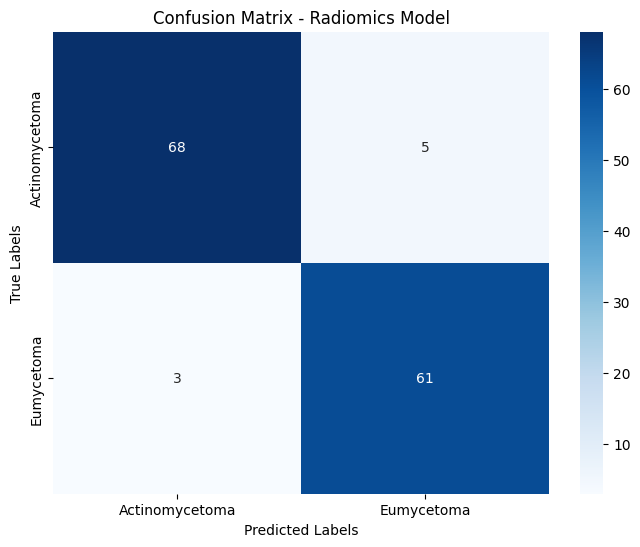

In [44]:
y_pred = model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

mcc_score = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc_score:.2f}")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred)